# Classification Task

In this assignment, you will:

1. Propose a custom classification task and create a corpus of documents that are annotated for this task.

2. Propose discriminative features to be included in the feature vector representation for the examples in this task and evaluate their utility by training and testing Logistic Regression models.

In [74]:
import os

datapath = '../data'
 
datapathtrain = '../data/train/'
train_file = os.path.join(datapathtrain, 'tweets.txt')
trainX, trainY = read_examples(train_file)

datapathtest = '../data/test/'
test_file = os.path.join(datapathtest, 'test_tweets.txt')
testX, testY = read_examples(test_file) 

datapathdev = '../data/dev/'
dev_file = os.path.join(datapathdev, 'dev_tweets.txt')
devX, devY = read_examples(dev_file)

# Specify features to use.
features = [word_features]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3184
Accuracy: 0.667


0.6666666666666666

### From textual examples to feature vectors

Read the documents in each dataset (train, dev, test) and generate the corresponding examples as feature vectors. Some skeleton code is provided below, but feel free to customize as you see fit for your task.

1. Tokenize each document using a spaCy tokenizer.

2. Create at least two feature functions, and include them in the *features* list.

    - A passing grade will be given to generic features that apply across arbitrary text classification problems (e.g., a feature for bigrams);

    - A better grade will be given for features that reveal your own understanding of your data. What features do you think will help for your particular problem? Would features based on higher level NLP processing tasks (syntactic parsing, coreference resolution) be useful? Your grade is not tied to whether accuracy goes up or down, so be creative!

    - You are free to read in any other external resources you like (dictionaries, document metadata, etc.), but make sure you include them in the `../data` folder.

3. Process each dataset into a set of examples, by mapping each document in the dataset to its corresponding set of examples. Process each example into a feature vector, using the feature functions from *features*. You can reuse feature vector representation code from previous assignments.
    - map example to a dictionary of feature names.
    - map feature names to unique feature IDs.
    - each example is a feature vector, where each feature ID is mapped to a feature value (e.g. word occurences).

In [ ]:
import spacy
from spacy.lang.en import English
from scipy import sparse
from sklearn.linear_model import LogisticRegression
import numpy as np
import re
# Create spaCy tokenizer.
spacy_nlp = English()

def remove_pattern(text):
    r = re.findall(r'@[\w]*', text)
    for i in r:
        text = re.sub(i, '', text)
    return text   

def spacy_tokenizer(text):
    remove_pattern(text)
    text.replace("[^a-zA-Z#]", " ")
    tokens = spacy_nlp.tokenizer(text)
    return [token.text for token in tokens]
                   
def read_examples(filename):
    X = []
    Y = []
    with open(filename, mode = 'r', encoding = 'utf-8') as file:
        for line in file:
            [label, text] = line.rstrip().split(' ', maxsplit = 1)
            X.append(text)
            Y.append(label)
    return X, Y

def word_features(tokens):
    feats = {}
    for word in tokens:
        feat = 'WORD_%s' % word
        if feat in feats:
            feats[feat] +=1
        else:
            feats[feat] = 1
    return feats

def add_features(feats, new_feats):
    for feat in new_feats:
        if feat in feats:
            feats[feat] += new_feats[feat]
        else:
            feats[feat] = new_feats[feat]
    return feats
                   
def docs2features(trainX, feature_functions, tokenizer):
    examples = []
    count = 0
    for doc in trainX:
        feats = {}
        tokens = tokenizer(doc)
        all_words = ' '.join([text for text in tokens])
        for func in feature_functions:
            add_features(feats, func(tokens))
        examples.append(feats)
        count +=1
        if count % 100 == 0:
            print('Processed %d examples into features' % len(examples))
    return examples
                   
def create_vocab(examples):
    feature_vocab = {}
    idx = 0
    for example in examples:
        for feat in example:
            if feat not in feature_vocab:
                feature_vocab[feat] = idx
                idx += 1
                
    return feature_vocab
                   
def features_to_ids(examples, feature_vocab):
    new_examples = sparse.lil_matrix((len(examples), len(feature_vocab)))
    for idx, example in enumerate(examples):
        for feat in example:
            if feat in feature_vocab:
                new_examples[idx, feature_vocab[feat]] = example[feat]
                
    return new_examples

### Train and evaluate

Write a `train_and_test` function that takes as input the training and test examples, trains a Logistic Regression model on the training examples and evaluates it on the test examples. You can use the default value for the `C` hyper-parameter, or tune it on the development examples. Report accuracy, or precision and recall, depending on the task.

In [ ]:
def train_and_test(trainX, trainY, devX, devY, feature_functions, tokenizer):
    # Pre-process training documents. 
    trainX_feat = docs2features(trainX, feature_functions, tokenizer)

    # Create vocabulary from features in training examples.
    feature_vocab = create_vocab(trainX_feat)
    print('Vocabulary size: %d' % len(feature_vocab))

    trainX_ids = features_to_ids(trainX_feat, feature_vocab)
    
    # Train LR model.
    lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000,multi_class='multinomial')
    lr_model.fit(trainX_ids, trainY)
    
    # Pre-process test documents. 
    devX_feat = docs2features(devX, feature_functions, tokenizer)
    devX_ids = features_to_ids(devX_feat, feature_vocab)
    
    # Test LR model.
    print('Accuracy: %.3f' % lr_model.score(devX_ids, devY))
    return lr_model.score(devX_ids, devY)

### Ablation experiments

Evaluate the impact of your features by training and testing with vs. without each feature.

In [17]:
# Specify features to use.
features = [word_features]
# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3184
Accuracy: 0.667


0.6666666666666666

In [18]:
import math
def len_feature(tokens):
    feat = {'DOC_LEN': math.log(len(tokens))}

    return feat

In [19]:
# Specify features to use.
features = [word_features, len_feature]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3185
Accuracy: 0.644


0.6444444444444445

In [20]:
def deictic_feature(tokens):
    pronouns = set(('i', 'my', 'me', 'we', 'us', 'our', 'you', 'your'))
    count = 0
    
    # YOUR CODE HERE
    for token in tokens:
        if (token.lower() in pronouns):
            count += 1  
    return {'DEICTIC_COUNT': count}

In [21]:
# Specify features to use.
features = [word_features,len_feature, deictic_feature]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3186
Accuracy: 0.644


0.6444444444444445

In [23]:
import re
def hash_feature(tokens):
    count = 0
    hashtags = []
    # Loop over the words in the tweet
    for token in tokens:
        if token=='#':
            count +=1
    return {'hashtags':count}

In [24]:
# Specify features to use.
features = [word_features,len_feature, deictic_feature,hash_feature]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3187
Accuracy: 0.644


0.6444444444444445

In [75]:
def read_lexicon(filename):
    lexicon = set()
    with open(filename, mode = 'r', encoding = 'ISO-8859-1') as file:
        # YOUR CODE HERE
        for line in file:
            if line[0]!=';' and line.strip()!='':
                lexicon.add(line.strip())

    return lexicon

lexicon_path = '../data'

sportlex_file = os.path.join(lexicon_path, 'sportwords.txt')
techlex_file = os.path.join(lexicon_path, 'technologywords.txt')
movielex_file = os.path.join(lexicon_path, 'movieswords.txt')
religlex_file = os.path.join(lexicon_path, 'religionwords.txt')

sportlex = read_lexicon(sportlex_file)
techlex = read_lexicon(techlex_file)
movielex =  read_lexicon(movielex_file)
religlex =  read_lexicon(religlex_file)


print(len(religlex), 'entries in the religion lexicon.')
print(len(movielex), 'entries in the movie lexicon.')
print(len(sportlex), 'entries in the sport lexicon.')
print(len(techlex), 'entries in the tech lexicon.')

8 entries in the religion lexicon.
6 entries in the movie lexicon.
7 entries in the sport lexicon.
7 entries in the tech lexicon.


In [26]:
def four_lexicon_features(tokens):
    feats = {'SPORTLEX': 0, 'TECHLEX': 0,'MOVIELEX':0,'RELIGLEX':0}
    # YOUR CODE HERE
    for word in tokens:
        if (word in sportlex):
            feats['SPORTLEX'] += 1
        elif (word in techlex):
             feats['TECHLEX'] += 1
        elif (word in religlex):
             feats['RELIGLEX'] += 1
        elif (word in movielex):
             feats['MOVIELEX'] += 1
     
    return feats

In [27]:
features = [word_features,len_feature, deictic_feature,four_lexicon_features]

# Evaluate LR model.
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3190
Accuracy: 0.733


0.7333333333333333

In [28]:
import nltk
from nltk.stem.porter import *
stemmer = PorterStemmer()

def lemma_features(tokens):
    lemma_token = []
    lemma_feat = {}
    for token in tokens:
        lemma_token.append(stemmer.stem(token)+'_'+token)
    for x in lemma_token:
        if('_' in x):
            temp = x.split('_')
            if(x not in  lemma_feat):
                lemma_feat[x] = 1
            elif(x in  lemma_feat):
                lemma_feat[x] += 1
    return lemma_feat

features = [lemma_features,four_lexicon_features,len_feature, deictic_feature]
train_and_test(trainX, trainY, devX, devY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3190
Accuracy: 0.733


0.7333333333333333

In [29]:
def train_and_testversion2(trainX, trainY, devX, devY, feature_functions, tokenizer,k):
    # Pre-process training documents. 
    trainX_feat = docs2features(trainX, feature_functions, tokenizer)
    feature_vocab = create_vocab(trainX_feat)
    feature_k_times = []
    for w,f in feature_vocab.items():
        if(f<k):
            feature_k_times.append(w)
    
    for example in trainX_feat:
        for key in example.copy().items():
            for word in feature_k_times:
                if key[0] == word:
                    example.pop(key[0])
    # Create vocabulary from features in training examples.
    feature_vocab = create_vocab(trainX_feat)
    print('Vocabulary size: %d' % len(feature_vocab))
    
    trainX_ids = features_to_ids(trainX_feat, feature_vocab)
    
    # Train LR model.
    lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000,multi_class='multinomial')
    lr_model.fit(trainX_ids, trainY)
    
    # Pre-process test documents. 
    devX_feat = docs2features(devX, feature_functions, tokenizer)
    devX_ids = features_to_ids(devX_feat, feature_vocab)
    
    # Test LR model.
    print('Accuracy: %.3f' % lr_model.score(devX_ids, devY))
    return lr_model.score(devX_ids, devY)

feature_functions=[word_features,len_feature,four_lexicon_features,lemma_features]
accuarcy_5 = train_and_testversion2(trainX, trainY, devX, devY, feature_functions, spacy_tokenizer,5)
accuarcy_3 = train_and_testversion2(trainX, trainY, devX, devY, feature_functions, spacy_tokenizer,3)
print('Accuracy for k = 5: %.3f' % accuarcy_5)
print('Accuracy for k = 3: %.3f' % accuarcy_3)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 6368
Accuracy: 0.711
Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 6370
Accuracy: 0.711
Accuracy for k = 5: 0.711
Accuracy for k = 3: 0.711


In [64]:
features = [word_features,lemma_features,four_lexicon_features]

# Evaluate LR model.
train_and_test(trainX, trainY, testX, testY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 6372
Accuracy: 0.789


0.7894736842105263

## Plot ROC or PR Curve

*Mandatory for graduate students, optional for undergraduate students.*

Take your best classifier and plot a <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">Receiver Operating Characteristic (ROC)</a> curve if you use accuracy for evaluation, by varying a threshold on the probabilistic output. You can use the <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html">sklearn implementation</a>, or implement your own. If you use precision and recall, plot a precision vs. recall (PR) curve instead.

C:\Users\Renu\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


4
Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Accuracy: 0.789
[[-0.72425056 -0.19738636  1.98299321 -1.0613563 ]
 [ 0.30216094 -0.53471934  0.69535162 -0.46279321]
 [-0.50250814 -0.91506843  2.21795086 -0.80037429]
 [-1.34349034 -0.9136471   3.41217257 -1.15503512]
 [-1.57495024 -1.31929964  3.1683466  -0.27409671]
 [-1.66665705  2.83071124 -0.64161702 -0.52243717]
 [-0.93300418  1.53973653 -0.69462898  0.08789663]
 [-2.19556732  2.85945703  0.2212218  -0.8851115 ]
 [-4.180185    5.6310387  -0.38355707 -1.06729662]
 [-4.35095191  5.30977943 -0.66418907 -0.29463844]
 [-1.00999641  2.33941674 -0.40400486 -0.92541547]
 [-1.54113157  1.85335432 -0.52284469  0.21062194]
 [-1.50329346  3.23145422 -1.13744507 -0.5907157 ]
 [-0.36641249 -0.27760096  0.46237023  0.18164322]
 [ 0.47945042 -1.62325266 -0.22892789  1.37273012]
 [ 0.10625744 -1.02905843 -0.05811389  0.98091488]
 [-0.77945441 -1.13179947  0.6674049   1.24384898]
 [ 0

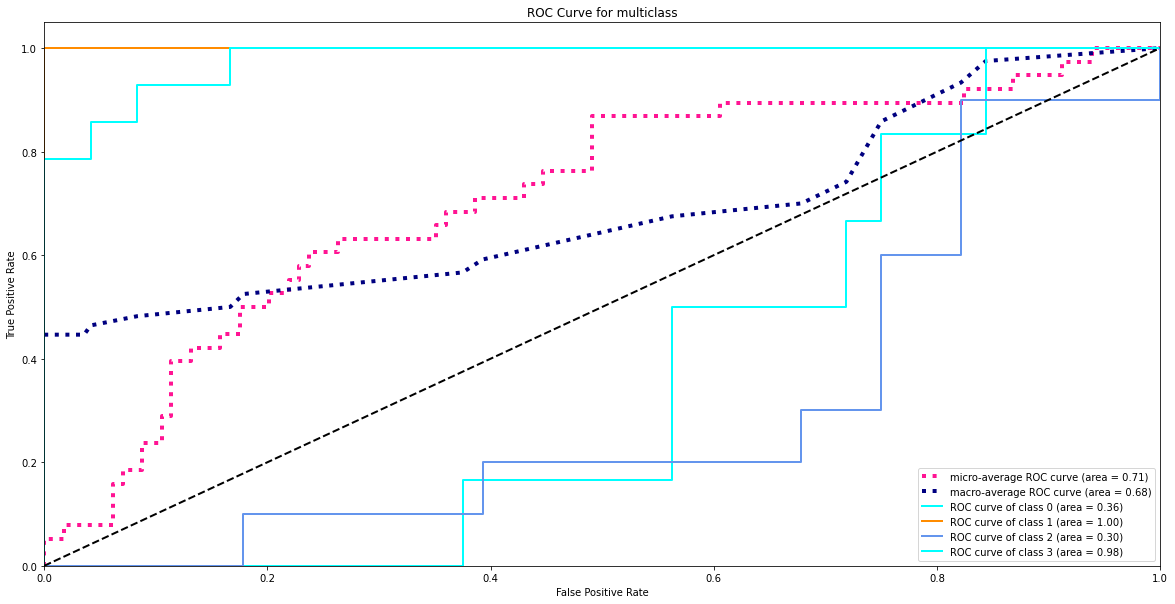

In [76]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
datapathtrain = '../data/train/'
train_file = os.path.join(datapathtrain, 'tweets.txt')
trainX, trainY = read_examples(train_file)

datapathtest = '../data/test/'
test_file = os.path.join(datapathtest, 'test_tweets.txt')
testX, testY = read_examples(test_file) 

datapathdev = '../data/dev/'
dev_file = os.path.join(datapathdev, 'dev_tweets.txt')
devX, devY = read_examples(dev_file)

# Binarize the output
y = label_binarize(trainY, classes=[0, 1, 2,3])
n_classes = y.shape[1]
print(n_classes)

feature_functions = [word_features,four_lexicon_features]
trainX_feat = docs2features(trainX, feature_functions, spacy_tokenizer)
feature_vocab = create_vocab(trainX_feat)
trainX_ids = features_to_ids(trainX_feat, feature_vocab)
lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000,multi_class='multinomial')
lr_model.fit(trainX_ids, trainY)

#testset
testX_feat = docs2features(testX, feature_functions, spacy_tokenizer)
testX_ids = features_to_ids(testX_feat, feature_vocab)
print('Accuracy: %.3f' % lr_model.score(testX_ids, testY))
lr_probability = lr_model.predict_proba(testX_ids)[:,1]

#devset
#devX_feat = docs2features(devX, feature_functions, spacy_tokenizer)
#devX_ids = features_to_ids(devX_feat, feature_vocab)
#print('Accuracy: %.3f' % lr_model.score(devX_ids, devY))
#lr_probability = lr_model.predict_proba(devX_ids)[:,1]

y_score = lr_model.fit(trainX_ids, trainY).decision_function(testX_ids)

#y_score = lr_model.fit(trainX_ids, trainY).decision_function(devX_ids)

print(y_score)

testY_class = []
devY_class = []

#for item in devY:
for item in testY:
    if(item == 'sport'):
        #devY_class.append([1,0,0,0])
        testY_class.append([1,0,0,0])
    elif(item == 'religion'):
        #devY_class.append([0,1,0,0])
        testY_class.append([0,1,0,0])
    elif (item == 'movie'):
        testY_class.append([0,0,1,0])
        #devY_class.append([0,0,1,0])
    else:
        testY_class.append([0,0,0,1])
        #devY_class.append([0,0,0,1])
        
testY_class=np.array(testY_class)
#devY_class=np.array(devY_class)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY_class[:, i], y_score[:, i])
    #fpr[i], tpr[i], _ = roc_curve(devY_class[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testY_class.ravel(), y_score.ravel())
#fpr["micro"], tpr["micro"], _ = roc_curve(devY_class.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
lw = 2
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for multiclass")
plt.legend(loc="lower right")
plt.show()

## Bonus points ##

Anything extra goes here.


In [ ]:
#Code for Dataset creation
import requests
import os
import json
import pandas as pd
import csv
import datetime
import dateutil.parser
import unicodedata
import time

def auth():
    return os.getenv('TOKEN')

def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/recent" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "basketball  lang:en"
max_results = 100

url = create_url(keyword, start_time,end_time, max_results)
json_response = connect_to_endpoint(url[0], headers, url[1])
print(json.dumps(json_response, indent=4, sort_keys=True))

csvFile = open("alltweets.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','source','tweet'])
csvFile.close()
def append_to_csv(json_response, fileName):

    counter = 0

#Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        author_id = tweet['author_id']
        created_at = dateutil.parser.parse(tweet['created_at'])

        if ('geo' in tweet):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        tweet_id = tweet['id']

        lang = tweet['lang']

        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        source = tweet['source']

        text = tweet['text']
        
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count, source, text]
        
        csvWriter.writerow(res)
        counter += 1
    csvFile.close()

append_to_csv(json_response, "alltweets.csv")

In [2]:
from wordcloud import WordCloud
def plotWorldcloud(trainX,tokenizer):
    for doc in trainX:
        feats = {}
        tokens = tokenizer(doc)
        all_words = ' '.join([text for text in tokens])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=90).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

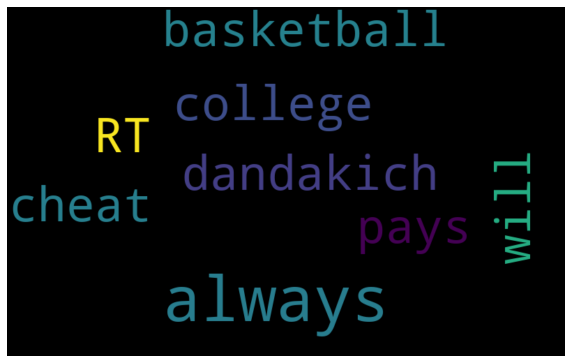

In [69]:
plotWorldcloud(trainX,spacy_tokenizer)

In [77]:
#code with parameter c = 1000
import os
from sklearn import datasets
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

datapath = '../data'

datapathtrain = '../data/train/'
train_file = os.path.join(datapathtrain, 'tweets.txt')
trainX, trainY = read_examples(train_file)

datapathtest = '../data/test/'
test_file = os.path.join(datapathtest, 'test_tweets.txt')
testX, testY = read_examples(test_file) 

datapathdev = '../data/dev/'
dev_file = os.path.join(datapathdev, 'dev_tweets.txt')
devX, devY = read_examples(dev_file)

feature_functions = [word_features,four_lexicon_features]
trainX_feat = docs2features(trainX, feature_functions, spacy_tokenizer)
feature_vocab = create_vocab(trainX_feat)
trainX_ids = features_to_ids(trainX_feat, feature_vocab)
devX_feat = docs2features(devX, feature_functions, spacy_tokenizer)
devX_ids = features_to_ids(devX_feat, feature_vocab)

clf = LogisticRegression(C= 1000, penalty= 'l1',multi_class='multinomial',solver='saga')
clf.fit(trainX_ids,trainY)
pred = clf.predict(devX_ids)
print('Non Zero weights:',np.count_nonzero(clf.coef_))

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Non Zero weights: 12734


C:\Users\Renu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [78]:
#code with parameter c = 100
import os
from sklearn import datasets
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

datapath = '../data'

datapathtrain = '../data/train/'
train_file = os.path.join(datapathtrain, 'tweets.txt')
trainX, trainY = read_examples(train_file)

datapathtest = '../data/test/'
test_file = os.path.join(datapathtest, 'test_tweets.txt')
testX, testY = read_examples(test_file) 

datapathdev = '../data/dev/'
dev_file = os.path.join(datapathdev, 'dev_tweets.txt')
devX, devY = read_examples(dev_file)

feature_functions = [word_features,four_lexicon_features]
trainX_feat = docs2features(trainX, feature_functions, spacy_tokenizer)
feature_vocab = create_vocab(trainX_feat)
trainX_ids = features_to_ids(trainX_feat, feature_vocab)
devX_feat = docs2features(devX, feature_functions, spacy_tokenizer)
devX_ids = features_to_ids(devX_feat, feature_vocab)

clf = LogisticRegression(C= 100, penalty= 'l1',multi_class='multinomial',solver='saga')
clf.fit(trainX_ids,trainY)
pred = clf.predict(devX_ids)
print('Non Zero weights:',np.count_nonzero(clf.coef_))

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Non Zero weights: 11673


C:\Users\Renu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [79]:
#code with parameter c = 10
#If we use L1 regularization in Logistic Regression all the Less important features will become zero
#sparsity increases as decrease C
import os
from sklearn import datasets
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

datapath = '../data'

datapathtrain = '../data/train/'
train_file = os.path.join(datapathtrain, 'tweets.txt')
trainX, trainY = read_examples(train_file)

datapathtest = '../data/test/'
test_file = os.path.join(datapathtest, 'test_tweets.txt')
testX, testY = read_examples(test_file) 

datapathdev = '../data/dev/'
dev_file = os.path.join(datapathdev, 'dev_tweets.txt')
devX, devY = read_examples(dev_file)

feature_functions = [word_features,four_lexicon_features]
trainX_feat = docs2features(trainX, feature_functions, spacy_tokenizer)
feature_vocab = create_vocab(trainX_feat)
trainX_ids = features_to_ids(trainX_feat, feature_vocab)
devX_feat = docs2features(devX, feature_functions, spacy_tokenizer)
devX_ids = features_to_ids(devX_feat, feature_vocab)

clf = LogisticRegression(C= 10, penalty= 'l1',multi_class='multinomial',solver='saga')
clf.fit(trainX_ids,trainY)
pred = clf.predict(devX_ids)
print('Non Zero weights:',np.count_nonzero(clf.coef_))

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Non Zero weights: 4398


C:\Users\Renu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [80]:
def train_and_test_version3(trainX, trainY, devX, devY, feature_functions, tokenizer):
    # Pre-process training documents. 
    trainX_feat = docs2features(trainX, feature_functions, tokenizer)
    # Create vocabulary from features in training examples.
    feature_vocab = create_vocab(trainX_feat)
    indextocheck1 = feature_vocab['WORD_basketball']
    indextocheck2 = feature_vocab['WORD_matches']
    indextocheck3 = feature_vocab['WORD_football']
    indextocheck4 = feature_vocab['WORD_software']
    
    print('Vocabulary size: %d' % len(feature_vocab))

    trainX_ids = features_to_ids(trainX_feat, feature_vocab)
    # Train LR model.
    lr_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'lbfgs', max_iter = 1000,multi_class='multinomial')
    lr_model.fit(trainX_ids,trainY)
    coefficientvalue_basketball = lr_model.coef_[0][indextocheck1]
    coefficientvalue_matches = lr_model.coef_[0][indextocheck2]
    coefficientvalue_football = lr_model.coef_[0][indextocheck3]
    coefficientvalue_software = lr_model.coef_[0][indextocheck4]
    print('Coefficient value for features basketball: %.3f' % coefficientvalue_basketball)
    print('Coefficient value for features matches: %.3f' % coefficientvalue_matches)
    print('Coefficient value for features football: %.3f' % coefficientvalue_football)
    print('Coefficient value for features software: %.3f' % coefficientvalue_software)
    
    # Pre-process test documents. 
    devX_feat = docs2features(devX, feature_functions, tokenizer)
    devX_ids = features_to_ids(devX_feat, feature_vocab)
    
    # Test LR model.
    print('Accuracy: %.3f' % lr_model.score(devX_ids, devY))
    return lr_model.score(devX_ids, devY)

features = [word_features]

# Evaluate LR model.
train_and_test_version3(trainX, trainY, testX, testY, features, spacy_tokenizer)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features
Vocabulary size: 3184
Coefficient value for features basketball: -0.226
Coefficient value for features matches: -0.035
Coefficient value for features football: -0.443
Coefficient value for features software: -0.172
Accuracy: 0.789


0.7894736842105263

In [66]:
#Interpretability using ELI5 library
import os
import eli5
from sklearn import datasets
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

datapath = '../data'

dev_file = os.path.join(datapath, 'dev_tweets.txt')
devX, devY = read_examples(test_file)
train_file = os.path.join(datapath, 'tweets.txt')
trainX, trainY = read_examples(train_file)
feature_functions = [word_features,four_lexicon_features]
trainX_feat = docs2features(trainX, feature_functions, spacy_tokenizer)
feature_vocab = create_vocab(trainX_feat)
trainX_ids = features_to_ids(trainX_feat, feature_vocab)
devX_feat = docs2features(devX, feature_functions, spacy_tokenizer)
devX_ids = features_to_ids(devX_feat, feature_vocab)

clf = LogisticRegression(C= 1000, penalty= 'l1',multi_class='multinomial',solver='saga')
clf.fit(trainX_ids,trainY)

eli5.show_weights(clf)

Processed 100 examples into features
Processed 200 examples into features
Processed 300 examples into features


C:\Users\Renu\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## Analysis ##
Include an analysis of the results that you obtained in the experiments above. It is improtant that results are formatted well, e.g. using tables, lists, etc.